<a href="https://colab.research.google.com/github/RiotChen/CDCS/blob/master/gdp_nowcast_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Siyuan Chen, 2024/11/23

In [2]:
!pip install fredapi

In [103]:
import pandas as pd
import numpy as np
import json

from math import sqrt

from datetime import datetime
from dateutil.relativedelta import relativedelta

from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [12]:
API_KEY = 'your_fred_api_key'

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [13]:
from fredapi import Fred
fred = Fred(api_key = API_KEY)

In [29]:
class JSONEncoder(json.JSONEncoder):
    def default(self, obj):
        if hasattr(obj, 'to_json'):
            return obj.to_json(orient='records')
        return json.JSONEncoder.default(self, obj)

In [14]:
def transform(column, transform_type):
  if transform_type == 'diff':
    column = column.diff()
  elif transform_type == 'qoq_pct':
    column = ((column / column.shift(1))**4 - 1.0) * 100
  elif transform_type == 'mom_pct':
    ((column / column.shift(1)) - 1.0) * 100
  else:
    pass

In [20]:
def get_fred_data(ticker, date):
  temp_fred_data = fred.get_series_as_of_date(ticker, date)
  fred_ts = temp_fred_data.groupby('date').last()[['value']].rename(columns = {'value': ticker})
  return fred_ts

In [16]:
quarterly_tickers = {
    'A261RX1Q020SBEA': 'qoq_pct',
    'ULCNFB': 'qoq_pct',
    'GDPC1': 'qoq_pct'
}

In [18]:
## I did find the data transformations are not conducted in the way Fred is handling here https://www.stlouisfed.org/research/economists/mccracken/fred-databases
## as many of the data is better taken log value to ensure better stationarity, but I did not have time to fix and re-run the scripts.

monthly_tickers = {
    # 'A261RX1Q020SBEA',
    'AMDMTI': 'mom_pct',
    'AMDMVS': 'mom_pct',
    'AMTMUO': 'mom_pct',
    'BOPTEXP': 'mom_pct',
    'BOPTIMP': 'mom_pct',
    'BUSINV': 'mom_pct',
    'CPIAUCSL': 'mom_pct',
    'CPILFESL': 'mom_pct',
    'DGORDER': 'mom_pct',
    'DSPIC96': 'mom_pct',
    'GACDFSA066MSFRBPHI': 'index',
    'GACDISA066MSFRBNY': 'index',
    # 'GDPC1',
    'HSN1F': 'mom_pct',
    'I42IMSM144SCEN': 'mom_pct',
    'INDPRO': 'mom_pct',
    'IQ': 'mom_pct',
    'IR': 'mom_pct',
    'JTSJOL': 'diff',
    'PAYEMS' : 'diff',
    'PCEC96': 'mom_pct',
    'PCEPI': 'mom_pct',
    'PCEPILFE': 'mom_pct',
    'PERMIT': 'diff',
    'PPIFIS': 'mom_pct',
    'RSAFS': 'mom_pct',
    'TCU': 'diff',
    'TTLCONS': 'mom_pct',
    # 'ULCNFB',
    'UNRATE': 'diff'
}

In [19]:
ticker_list = list(quarterly_tickers.keys()) + list(monthly_tickers.keys())
ticker_mapping = {**quarterly_tickers, **monthly_tickers}

### **The data is loaded from 2022-09 on a monthly basis till 2024-09, so for each of the point-at-time nowcast, only available data is used and it mimics the process when we receive the new data.**

In [21]:
start_dt = '2022-09'

end_dt = '2024-09'


start = datetime.strptime(start_dt, '%Y-%m')

end = datetime.strptime(end_dt, '%Y-%m')

step = relativedelta(months=1)

date_list = []

while start <= end:
  date_list.append(start.date().strftime("%Y-%m"))
  start += step

In [22]:
q_step = relativedelta(months=3)

start = datetime.strptime(start_dt, '%Y-%m')

end = datetime.strptime(end_dt, '%Y-%m')

q_date_list = []

while start <= end:
  q_date_list.append(start.date().strftime("%Y-%m"))
  start += q_step

## **On Handling the data revision**

- Since we are running nowcast, at each given point of time the data available for the model input is always a fraction of the latest data. For better bact-test/evaluate the nowcasting performance, I load the latest data (with the latest revision available that point) so the model generated GDP nowcast is "up-to-date" yet no peek-ahead of revision.

In [24]:
def load_fred_by_date(date):
  print('fred data load as of ' + date + ' has started.')
  fred_list = []
  fred_qdata_list = []
  fred_mdata_list = []
  for ticker in list(ticker_list):
    transformation_type = ticker_mapping[ticker]
    temp_fred_ts = get_fred_data(ticker, date)

    if transformation_type == 'mom_pct':
      temp_fred_ts = ((temp_fred_ts / temp_fred_ts.shift(1)) - 1.0) * 100
    elif transformation_type == 'diff':
      temp_fred_ts = temp_fred_ts.diff()
    elif transformation_type == 'qoq_pct':
      temp_fred_ts = ((temp_fred_ts / temp_fred_ts.shift(1))**4 - 1.0) * 100

    if ticker in list(monthly_tickers.keys()):
      temp_fred_ts.index = pd.PeriodIndex(temp_fred_ts.index.tolist(), freq='M')
      fred_mdata_list.append(temp_fred_ts)
    else:
      temp_fred_ts.index = pd.PeriodIndex(temp_fred_ts.index.tolist(), freq='Q')
      fred_qdata_list.append(temp_fred_ts)

    fred_list.append(temp_fred_ts)
    print(ticker + ' finished')

  monthly = pd.concat(fred_mdata_list, axis = 1).dropna(how = 'all').sort_index().astype(float)
  quarterly = pd.concat(fred_qdata_list, axis = 1).dropna(how = 'all').sort_index().astype(float)
  return monthly, quarterly

In [25]:
m_ts_dict = {}
q_ts_dict = {}
for date in date_list:
  monthly_temp, quarterly_temp = load_fred_by_date(date)
  m_ts_dict[date] = monthly_temp
  q_ts_dict[date] = quarterly_temp

fred data load as of 2022-09 has started.
A261RX1Q020SBEA finished
ULCNFB finished
GDPC1 finished
AMDMTI finished
AMDMVS finished
AMTMUO finished
BOPTEXP finished
BOPTIMP finished
BUSINV finished
CPIAUCSL finished
CPILFESL finished
DGORDER finished
DSPIC96 finished
GACDFSA066MSFRBPHI finished
GACDISA066MSFRBNY finished
HSN1F finished
I42IMSM144SCEN finished
INDPRO finished
IQ finished
IR finished
JTSJOL finished
PAYEMS finished
PCEC96 finished
PCEPI finished
PCEPILFE finished
PERMIT finished
PPIFIS finished
RSAFS finished
TCU finished
TTLCONS finished
UNRATE finished
fred data load as of 2022-10 has started.
A261RX1Q020SBEA finished
ULCNFB finished
GDPC1 finished
AMDMTI finished
AMDMVS finished
AMTMUO finished
BOPTEXP finished
BOPTIMP finished
BUSINV finished
CPIAUCSL finished
CPILFESL finished
DGORDER finished
DSPIC96 finished
GACDFSA066MSFRBPHI finished
GACDISA066MSFRBNY finished
HSN1F finished
I42IMSM144SCEN finished
INDPRO finished
IQ finished
IR finished
JTSJOL finished
PAYEMS fin

In [30]:
## Save the time-series to local file so I don't need to re-run the above process which is quite slow :)

with open('m_ts_dict.json', 'w') as fp:
    json.dump(m_ts_dict, fp, cls=JSONEncoder)

with open('q_ts_dict.json', 'w') as fp:
    json.dump(q_ts_dict, fp, cls=JSONEncoder)

## **Nowcasting Model - Dynamic Factor Model:**

- The first model in my mind to handle the "feature selection" while also able to deal with the multicolinearity is elastic net, from my experience of doing FX modelling, I tried to use elastic net to address the highly inter-correlated varaibles (while in the end I found for FX, doing a simple trimmed mean will provide a better bact-test result...)

- And being 100% honest, while searching the "best" model, I found the staff of New York Fed is using Dynamic Factor Model for their nowcasting - instead of "select" features or macro factors, we need to extract the latent dynamic factors through factor analysis and state-space modeling the dynamic structure (with shared dynamics), and it can also address the multicolinearity.

- The factors used are directly from the information shared in the test pdf file.

In [32]:
factor_mapping = {
    'A261RX1Q020SBEA': ['Global', 'Others'],
    'ULCNFB': ['Global', 'Labor'],
    'AMDMTI': ['Global', 'Manufacturing'],
    'AMDMVS': ['Global', 'Manufacturing'],
    'AMTMUO': ['Global', 'Manufacturing'],
    'BOPTEXP': ['Global', 'International Trade'],
    'BOPTIMP': ['Global', 'International Trade'],
    'BUSINV': ['Global', 'Manufacturing'],
    'CPIAUCSL': ['Global', 'Others'],
    'CPILFESL': ['Global', 'Others'],
    'DGORDER': ['Global', 'Manufacturing'],
    'DSPIC96': ['Global', 'Income'],
    'GACDFSA066MSFRBPHI': ['Global', 'Surveys'],
    'GACDISA066MSFRBNY': ['Global', 'Surveys'],
    'HSN1F': ['Global', 'Housing and Contruction'],
    'I42IMSM144SCEN': ['Global', 'Manufacturing'],
    'INDPRO': ['Global', 'Manufacturing'],
    'IQ': ['Global', 'International Trade'],
    'IR': ['Global', 'International Trade'],
    'JTSJOL': ['Global', 'Labor'],
    'PAYEMS': ['Global', 'Labor'],
    'PCEC96': ['Global', 'Others'],
    'PCEPI': ['Global', 'Others'],
    'PCEPILFE': ['Global', 'Others'],
    'PERMIT': ['Global', 'Housing and Contruction'],
    'PPIFIS': ['Global', 'Others'],
    'RSAFS': ['Global', 'Retail and Comsuption'],
    'TCU': ['Global', 'Manufacturing'],
    'TTLCONS': ['Global', 'Housing and Contruction'],
    'UNRATE': ['Global', 'Labor'],
    'GDPC1': ['Global', 'Others']
}

In [33]:
start = '2000'
input_m = m_ts_dict['2022-09'].loc[start:, :]
gdp_ticker = 'GDPC1'
input_q = q_ts_dict['2022-09'].loc[start:, [gdp_ticker]]


model = sm.tsa.DynamicFactorMQ(
    input_m, endog_quarterly=input_q,
     factors=factor_mapping)

In [34]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Model Specification: Dynamic Factor Model                         
===========================================================================================
Model:                Dynamic Factor Model   # of monthly variables:                     28
                   + 9 factors in 9 blocks   # of quarterly variables:                    1
                   + Mixed frequency (M/Q)   # of factor blocks:                          9
                     + AR(1) idiosyncratic   Idiosyncratic disturbances:              AR(1)
Sample:                            2000-01   Standardize variables:                    True
                                 - 2022-08                                                 
                                                           Observed variables / factor loadings                                                           
==========================================================================================================================================================
     Dep. variable     Global Manufacturing     Others International Trade       Labor Housing and Contruction    Surveys     Income Retail and Comsuption
----------------------------------------------------------------------------------------------------------------------------------------------------------
            AMDMTI       X          X                                                                                                                     
            AMDMVS       X          X                                                                                                                     
            AMTMUO       X          X                                                                                                                     
           BOPTEXP       X                                      X                                                                                         
           BOPTIMP       X                                      X                                                                                         
            BUSINV       X          X                                                                                                                     
          CPIAUCSL       X                        X                                                                                                       
          CPILFESL       X                        X                                                                                                       
           DGORDER       X          X                                                                                                                     
           DSPIC96       X                                                                                                      X                         
GACDFSA066MSFRBPHI       X                                                                                           X                                    
 GACDISA066MSFRBNY       X                                                                                           X                                    
             HSN1F       X                                                                        X                                                       
    I42IMSM144SCEN       X          X                                                                                                                     
            INDPRO       X          X                                                                                                                     
                IQ       X                                      X                                                                                         
                IR       X                                      X                                                   

In [414]:
results = model.fit()

In [415]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               Dynamic Factor Results                              
===================================================================================
Dep. Variable:       "AMDMTI", and 28 more   No. Observations:                  272
Model:                Dynamic Factor Model   Log Likelihood               -7413.682
                   + 9 factors in 9 blocks   AIC                          15095.363
                   + Mixed frequency (M/Q)   BIC                          15578.541
                     + AR(1) idiosyncratic   HQIC                         15289.342
Date:                     Sat, 23 Nov 2024   EM Iterations                      111
Time:                             06:28:38                                         
Sample:                         01-31-2000                                         
                              - 08-31-2022                                         
Covariance Type:              Not computed                                         
                                                                                    Observation equation:                                                                                     
==============================================================================================================================================================================================
  Factor loadings:     Global Manufacturing     Others International Trade       Labor Housing and Contruction    Surveys     Income Retail and Comsuption    idiosyncratic: AR(1)        var.
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
            AMDMTI      -0.09         -0.38          .                   .           .                       .          .          .                     .                    0.65        0.47
            AMDMVS      -0.24          0.19          .                   .           .                       .          .          .                     .                   -0.36        0.40
            AMTMUO      -0.10         -0.22          .                   .           .                       .          .          .                     .                    0.44        0.71
           BOPTEXP      -0.26             .          .               -0.07           .                       .          .          .                     .                   -0.13        0.34
           BOPTIMP      -0.22             .          .                0.14           .                       .          .          .                     .                   -0.36        0.47
            BUSINV      -0.15         -0.39          .                   .           .                       .          .          .                     .                    0.79        0.18
          CPIAUCSL      -0.20             .      -0.39                   .           .                       .          .          .                     .                   -0.12        0.09
          CPILFESL      -0.16             .      -0.31                   .           .                       .          .          .                     .                    0.37        0.73
           DGORDER      -0.15          0.09          .                   .           .                       .          .          .                     .                   -0.42        0.68
           DSPIC96       0.08             .          .                   .           .                       .          .       0.97                     .                    0.46        0.00
GACDFSA066MSFRBPHI      -0.19             .          .                   .           .                       .       0.58          .                     .                    0.58        0.26
 GACDISA066MSFRBNY      -0.18             .          .                   .     

In [450]:
# The original point forecasts are monthly
point_forecasts_m = results.forecast('Oct 2024')[gdp_ticker]

# Resample to quarterly frequency by taking the value in the last
# month of each quarter
point_forecasts_q = point_forecasts_m.resample('Q').last()

print('Baseline (October 2024) forecast for real GDP growth'
      f' in 2024Q4: {point_forecasts_q["2024Q4"]:.2f}%')

Baseline (October 2024) forecast for real GDP growth in 2024Q4: 2.06%


<ipython-input-450-bbedf7396033>:6: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  point_forecasts_q = point_forecasts_m.resample('Q').last()


In [38]:
res_dict = {'2022-09': results}
# Apply our results to the remaining vintages
for date in list(m_ts_dict.keys())[1:]:
    print('start to update ' + date)
    # Get updated data for the vintage
    updated_endog_m = m_ts_dict[date].loc[start:, :]
    updated_endog_q = q_ts_dict[date].loc[start:, [gdp_ticker]]

    # Get updated results for for the vintage
    res_dict[date] = results.apply(
        updated_endog_m, endog_quarterly=updated_endog_q)

start to update 2022-10
start to update 2022-11
start to update 2022-12
start to update 2023-01
start to update 2023-02
start to update 2023-03
start to update 2023-04
start to update 2023-05
start to update 2023-06
start to update 2023-07
start to update 2023-08
start to update 2023-09
start to update 2023-10
start to update 2023-11
start to update 2023-12
start to update 2024-01
start to update 2024-02
start to update 2024-03
start to update 2024-04
start to update 2024-05
start to update 2024-06
start to update 2024-07
start to update 2024-08
start to update 2024-09


In [430]:
res_dict

{'2022-09': <statsmodels.tsa.statespace.mlemodel.MLEResultsWrapper at 0x7f45ba1ec9d0>,
 '2022-10': <statsmodels.tsa.statespace.mlemodel.MLEResultsWrapper at 0x7f45b9dba560>,
 '2022-11': <statsmodels.tsa.statespace.mlemodel.MLEResultsWrapper at 0x7f45ba3adb40>,
 '2022-12': <statsmodels.tsa.statespace.mlemodel.MLEResultsWrapper at 0x7f45b86d2b00>,
 '2023-01': <statsmodels.tsa.statespace.mlemodel.MLEResultsWrapper at 0x7f45b94b47c0>,
 '2023-02': <statsmodels.tsa.statespace.mlemodel.MLEResultsWrapper at 0x7f45b94b7f70>,
 '2023-03': <statsmodels.tsa.statespace.mlemodel.MLEResultsWrapper at 0x7f45ba0690f0>,
 '2023-04': <statsmodels.tsa.statespace.mlemodel.MLEResultsWrapper at 0x7f45b9d60340>,
 '2023-05': <statsmodels.tsa.statespace.mlemodel.MLEResultsWrapper at 0x7f45ba260c40>,
 '2023-06': <statsmodels.tsa.statespace.mlemodel.MLEResultsWrapper at 0x7f45b8db5db0>,
 '2023-07': <statsmodels.tsa.statespace.mlemodel.MLEResultsWrapper at 0x7f45b8db4700>,
 '2023-08': <statsmodels.tsa.statespace.mle

In [443]:
news = res_dict['2024-09'].news(
    res_dict['2024-08'], impact_date='2024-10',
    impacted_variable=gdp_ticker,
    comparison_type='previous')

The survey based manufacturing data came in way less than the forecasted value which has the second/third biggest imapct of the final forecast

While capacity utilization total industry has a larger negative impact from its bigger weights.

In [446]:
details = news.details_by_impact
details.index = details.index.droplevel(['impact date', 'impacted variable'])
details['absolute impact'] = np.abs(details['impact'])
details = (details.sort_values('absolute impact', ascending=False)
                  .drop('absolute impact', axis=1))
details.iloc[:10].round(2)

observed  forecast (prev)   news  weight  \
update date updated variable                                               
2024-07     TCU                    -0.58             0.15  -0.73    2.41   
2024-08     GACDFSA066MSFRBPHI     -7.00             9.63 -16.63    0.05   
            GACDISA066MSFRBNY      -4.70             1.52  -6.22    0.07   
2024-07     INDPRO                 -0.64             0.28  -0.92    0.32   
            IQ                      0.74             0.16   0.58    0.16   
2024-06     AMTMUO                 -1.36             0.07  -1.43    0.06   
2024-07     DGORDER                 9.89             3.84   6.06    0.01   
            CPIAUCSL                0.15             0.21  -0.05   -1.18   
2024-06     BOPTEXP                 1.50             0.67   0.83    0.06   
2024-07     UNRATE                  0.20            -0.10   0.30   -0.15   

                                impact  
update date updated variable            
2024-07     TCU                  -1.76  
2024-08     GACDFSA066MSFRBPHI   -0.90  
            GACDISA066MSFRBNY    -0.41  
2024-07     INDPRO               -0.29  
            IQ                    0.09  
2024-06     AMTMUO               -0.09  
2024-07     DGORDER               0.06  
            CPIAUCSL              0.06  
2024-06     BOPTEXP               0.05  
2024-07     UNRATE               -0.04

In [445]:
details

observed  \
impact date impacted variable update date updated variable                 
2024-10     GDPC1             2024-06     AMTMUO               -1.356537   
                                          BOPTEXP               1.500729   
                                          BOPTIMP               0.603836   
                                          BUSINV                0.340312   
                                          I42IMSM144SCEN        0.204953   
                              2024-07     AMDMTI                0.133458   
                                          AMDMVS                1.084465   
                                          CPIAUCSL              0.154928   
                                          CPILFESL              0.165229   
                                          DGORDER               9.892591   
                                          DSPIC96               0.106572   
                                          HSN1F                10.628743   
                                          INDPRO               -0.638053   
                                          IQ                    0.741240   
                                          IR                    0.141343   
                                          PAYEMS              114.000000   
                                          PCEC96                0.376960   
                                          PCEPI                 0.155049   
                                          PCEPILFE              0.161129   
                                          PERMIT              -48.000000   
                                          PPIFIS                0.098249   
                                          RSAFS                 0.968327   
                                          TCU                  -0.575800   
                                          UNRATE                0.200000   
                              2024-08     GACDFSA066MSFRBPHI   -7.000000   
                                          GACDISA066MSFRBNY    -4.700000   

                                                              forecast (prev)  \
impact date impacted variable update date updated variable                      
2024-10     GDPC1             2024-06     AMTMUO                     0.068857   
                                          BOPTEXP                    0.669944   
                                          BOPTIMP                    0.637762   
                                          BUSINV                     0.289301   
                                          I42IMSM144SCEN             0.288331   
                              2024-07     AMDMTI                     0.128025   
                                          AMDMVS                     0.267099   
                                          CPIAUCSL                   0.205131   
                                          CPILFESL                   0.158068   
                                          DGORDER                    3.835634   
                                          DSPIC96                    0.208247   
                                          HSN1F                     -0.632886   
                                          INDPRO                     0.282085   
                                          IQ                         0.157928   
                                          IR                         0.250166   
                                          PAYEMS                   277.539233   
                                          PCEC96                     0.446214   
                                          PCEPI                      0.161951   
                                          PCEPILFE                   0.163707   
                                          PERMIT                   -29.806319   
                                          PPIFIS                     0.219828   
                                          RSAFS                      0.5

In [447]:
nowcast_ts

,GDPC1,forecast date
2022Q4,0.328118,2022-10
2022Q4,0.942078,2022-11
2022Q4,-1.442814,2022-12
2023Q1,0.912440,2023-01
2023Q1,-1.017611,2023-02
2023Q1,-3.453020,2023-03
2023Q2,0.479081,2023-04
2023Q2,2.239936,2023-05
2023Q2,1.837800,2023-06
2023Q3,1.603553,2023-07


In [61]:
nowcast_ts = pd.DataFrame()

for i in range(len(q_date_list)-1):
  for date in res_dict.keys():
    curr_date = q_date_list[i]
    forecast_date = q_date_list[i+1]
    if date> curr_date and date <=forecast_date:
      temp_nowcast = res_dict[date].forecast(forecast_date)[gdp_ticker]
      temp_nowcast_q = pd.DataFrame(temp_nowcast.resample('Q').last())
      temp_nowcast_q['forecast date'] = date
      # print(temp_nowcast_q.iloc[-1:])
      nowcast_ts = pd.concat([nowcast_ts, temp_nowcast_q])

<ipython-input-61-91cb0591f5dc>:9: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  temp_nowcast_q = pd.DataFrame(temp_nowcast.resample('Q').last())
<ipython-input-61-91cb0591f5dc>:9: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  temp_nowcast_q = pd.DataFrame(temp_nowcast.resample('Q').last())
<ipython-input-61-91cb0591f5dc>:9: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  temp_nowcast_q = pd.DataFrame(temp_nowcast.resample('Q').last())
<ipython-input-61-91cb0591f5dc>:9: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  temp_nowcast_q = pd.DataFrame(temp_nowcast.resample('Q').last())
<ipython-input-61-91cb0591f5dc>:9: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before re

In [96]:

merged_nowcast_actual = pd.DataFrame(nowcast_ts.reset_index().groupby(['index'])['GDPC1'].last()).rename(columns = {'GDPC1': 'GDP Nowcast'}).merge(pd.DataFrame(q_ts_dict['2024-09']['GDPC1']).loc['2022Q4':], left_index = True, right_index = True, how = 'left')

<Axes: title={'center': 'Nowcast GDP with peek-ahead vs. Actual GDP'}, xlabel='index'>

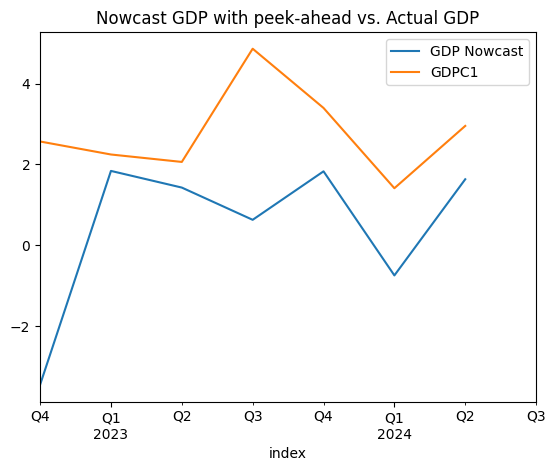

In [256]:
## For sensitivity check, shift it by one period, should be close in trend if peek-ahead is correctly handled (info leak on purpose)

pd.DataFrame(nowcast_ts.reset_index().groupby(['index'])['GDPC1'].last()).rename(columns = {'GDPC1': 'GDP Nowcast'}).shift(-1).merge(pd.DataFrame(q_ts_dict['2024-09']['GDPC1']).loc['2022Q4':], left_index = True, right_index = True, how = 'left').plot(title = 'Nowcast GDP with peek-ahead vs. Actual GDP')

<Axes: title={'center': 'Nowcast GDP vs. Actual GDP'}, xlabel='index'>

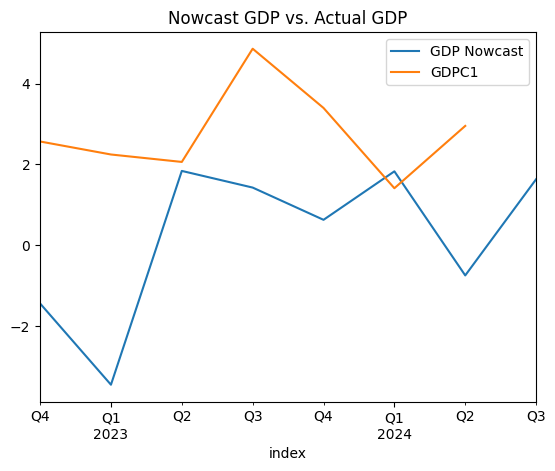

In [255]:
merged_nowcast_actual.plot(title = 'Nowcast GDP vs. Actual GDP')

In [257]:
#calculate RMSE, did not have time to run a base-line model to compare but I guess the result won't be super good.

sqrt(mean_squared_error(merged_nowcast_actual.dropna()['GDP Nowcast'], merged_nowcast_actual['GDPC1'].dropna()))

3.4207390585034063

### **Construct the GDP Nowcast based signal**

Sensitivity - A simple momentum-like signal which compares the current nowcast vs. the 6-month exponential weighted moving average of nowcast, if the current nowcast value for the next quarter GDP is significantly lower than the 6m ewma (50% lower) - the market will be riskier and we go to safe-haven asset, in this case we de-risk the portfolio by holding more gold

- The original portfolio is simply 100% SPX, while the above risk-on-risk-off like signal is triggered, we will UW 40% gold funded by 40% UW of SPX.

- The 2-year back-test shows a 2% out-performance of the signal with the sharpe ratio increased from 1.46 to 1.58

In [329]:
assets = pd.read_csv('./assets.csv').set_index('DATE')

In [330]:
spx_gld = assets[['SPX', 'GOLD']]
spx_gld.index = pd.to_datetime(spx_gld.index)

In [331]:
monthly_ret = spx_gld.resample('M').ffill().pct_change()
monthly_ret.index = pd.PeriodIndex(monthly_ret.index.tolist(), freq='M')

<ipython-input-331-600075e6d9ca>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_ret = spx_gld.resample('M').ffill().pct_change()


In [332]:
monthly_nowcast = nowcast_ts.reset_index().set_index('forecast date')[['GDPC1']]

In [333]:
monthly_nowcast['6m_ewm'] = monthly_nowcast['GDPC1'].ewm(6).mean()

In [399]:
monthly_nowcast['GOLD'] = monthly_nowcast.apply(lambda row: 0.4 if row['GDPC1']*2 < row['6m_ewm'] else 0, axis=1)
monthly_nowcast['SPX'] = 1-monthly_nowcast['GOLD']

**Do we have peek-ahead info here? I think the answer is yes, but minor**

The data from fred was fetched as of month-start (I believe), so technically we are using month-begin known info to forecast the return of that same month of SPX and GOLD - there will be 1 day overlap, so the above simple conceptual signal is for illustration purpose


In [400]:
risk_on_risk_off = pd.DataFrame(((monthly_nowcast[['SPX', 'GOLD']].iloc[:-1] * monthly_ret.loc['2022-10':].values).sum(axis = 1)+1).cumprod(), columns = ['Risk-on Risk-off Signal'])
risk_on_risk_off.index.name = None
risk_on_risk_off.index = pd.PeriodIndex(risk_on_risk_off.index.tolist(), freq='M')

In [401]:
risk_on_risk_off = pd.DataFrame(((monthly_nowcast[['SPX', 'GOLD']].iloc[:-1] * monthly_ret.loc['2022-10':].values).sum(axis = 1)), columns = ['Risk-on Risk-off Signal'])
risk_on_risk_off.index.name = None
risk_on_risk_off.index = pd.PeriodIndex(risk_on_risk_off.index.tolist(), freq='M')

In [402]:
risk_on_risk_off_cumulative = (risk_on_risk_off+1).cumprod()

In [403]:
spx = pd.DataFrame((monthly_ret.loc['2022-10':][['SPX']]), columns = ['SPX'])
spx_cumulative = (spx+1).cumprod()

In [404]:
backtest_ret = risk_on_risk_off.merge(spx, left_index = True, right_index = True)

In [413]:
backtest_perf = risk_on_risk_off_cumulative.merge(spx_cumulative, left_index = True, right_index = True)

In [423]:
backtest_perf

,Risk-on Risk-off Signal,SPX
2022-10,1.079863,1.079863
2022-11,1.137909,1.137909
2022-12,1.112063,1.070805
2023-01,1.180736,1.136930
2023-02,1.137427,1.107242
2023-03,1.196863,1.146053
2023-04,1.214388,1.162834
2023-05,1.217403,1.165720
2023-06,1.296202,1.241174
2023-07,1.336565,1.279823


<Axes: >

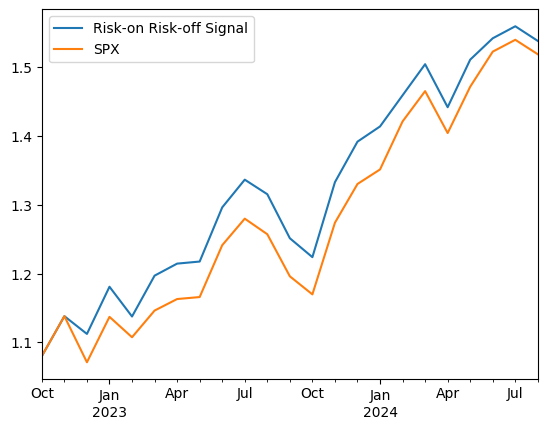

In [407]:
risk_on_risk_off_cumulative.merge(spx_cumulative, left_index = True, right_index = True).plot()

In [408]:
rf = 0.02

def sharpe_ratio(return_series, N, rf):
    mean = return_series.mean() * N -rf
    sigma = return_series.std() * np.sqrt(N)
    return mean / sigma

In [412]:
pd.DataFrame(backtest_ret.apply(sharpe_ratio, args=(12,rf),axis=0), columns = ['Sharpe Ratio'])

,Sharpe Ratio
Risk-on Risk-off Signal,1.578464
SPX,1.459330
